# S1 Multiplicity
.... background and bullshit

In [1]:
import datetime

In [2]:
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

2017-04-03 11:33:46


In [3]:
from __future__ import print_function
import sys
import os
from glob import glob
from time import time

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import pandas as pd
import tables as tb
import numpy as np
import math

In [5]:
from invisible_cities.database import load_db
import invisible_cities.sierpe.blr as blr
import invisible_cities.core.mpl_functions as mpl
import invisible_cities.reco.wfm_functions as wfm
import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions_c as cpf
import invisible_cities.reco.peak_functions as pf
import invisible_cities.reco.pmaps_functions as pmf

In [6]:
from invisible_cities.reco.pmap_io import pmap_writer, S12, S2Si

from invisible_cities.core.configure import configure, print_configuration

from invisible_cities.core.system_of_units_c import units
from invisible_cities.cities.base_cities import PmapCity, SensorParams
from invisible_cities.cities.base_cities import S12Params as S12P

In [7]:
from invisible_cities.core.core_functions import define_window
from invisible_cities.core.core_functions import lrange
from collections import namedtuple

In [8]:
from invisible_cities.reco.params import S12Params, ThresholdParams, CalibratedSum, PMaps,\
                                         SensorParams, CalibParams, PmapParams, CalibratedPMT, S1PMaps

In [9]:
from matplotlib.figure import Figure

In [10]:
%load_ext Cython

In [11]:
from event_pmaps import compare_S1

### Input

In [12]:
run_number=3389
#run_number=0

In [13]:
ic_data = os.path.join(os.environ['IC_DATA'])
files  = glob(ic_data + 'LSC/' + str(run_number) + '/' +  'dst_waves.gdcsnext.*_3389.root.h5')
#files  = [ic_data + 'Montecarlo/' + 'dst_NEXT_v0_08_09_Kr_ACTIVE_0_0_7bar_RWF_10000.root.h5']

In [14]:
print(files)

['/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.000_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.001_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.002_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.003_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.004_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.005_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.006_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.007_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.008_3389.root.h5', '/Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.009_3389.root.h5']


### pmtrwf and sipmrwf vectors

To get vectors use **get_vectors(file)** in tbl_functions

In [15]:
def _calib_vectors(self):
        """Provisional fix for calib vectors"""
        channel_id = np.array([0,1,4,5,8,18,22,23,26,27,30])
        coeff_blr = np.array([1.61,1.62,1.61,1.61,1.61,
                          0.8,0.8,0.8,0.8,0.8,1.60,
                          1.0]) * 0.001
        coeff_c = np.array([2.94,2.75,3.09,2.81,2.88,
                        1.,1.,1.,1.,1.,2.76,
                        1.0]) * 1e-6
        adc_to_pes = np.array([25.17,22.15,33.57,23.88,21.55,
                           26.49,25.39,27.74,23.78,20.83,26.56,
                           0.])
        pmt_active = list(range(11))

        DataSiPM = load_db.DataSiPM()
        self.P   = CalibVectors(channel_id = channel_id,
                                coeff_blr  = coeff_blr,
                                coeff_c    = coeff_c,
                                adc_to_pes_pmt = adc_to_pes,
                                adc_to_pes_sipm = DataSiPM.adc_to_pes.values,
                                pmt_active  = pmt_active)

### S1 multiplicity

In [16]:
DataPMT = load_db.DataPMT(run_number)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
coeff_c    = abs(DataPMT.coeff_c.values)
coeff_blr  = abs(DataPMT.coeff_blr.values)
DataSiPM   = load_db.DataSiPM()
adc_to_pes_sipm = DataSiPM.adc_to_pes.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()
xs = DataSiPM.X.values
ys = DataSiPM.Y.values

163 in: /Users/alej/Desktop/IC_DATA/LSC/3389/dst_waves.gdcsnext.000_3389.root.h5... 
----------
{0: [array([ 216900.,  216925.,  216950.,  216975.,  217000.,  217025.]), array([ 1.45834054,  3.11860104,  4.02788655,  3.61979037,  2.2690211 ,
        0.87841431])]}


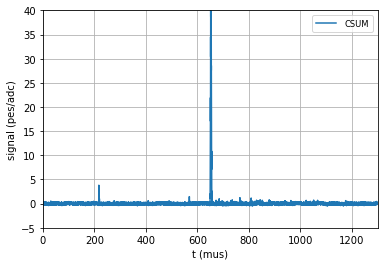

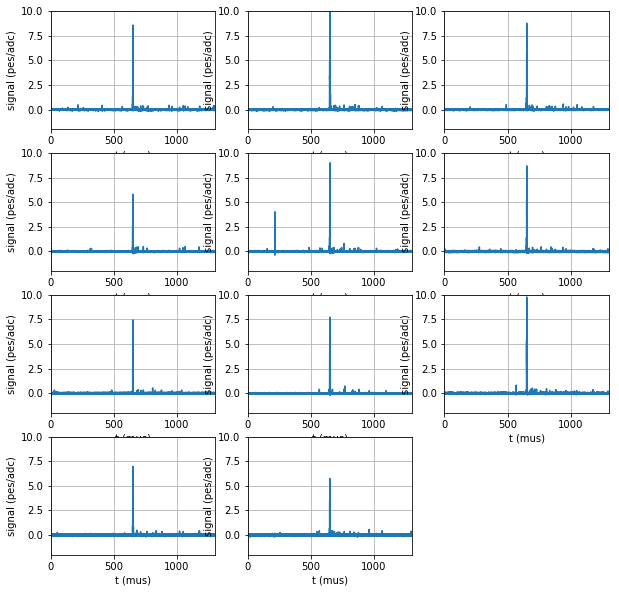

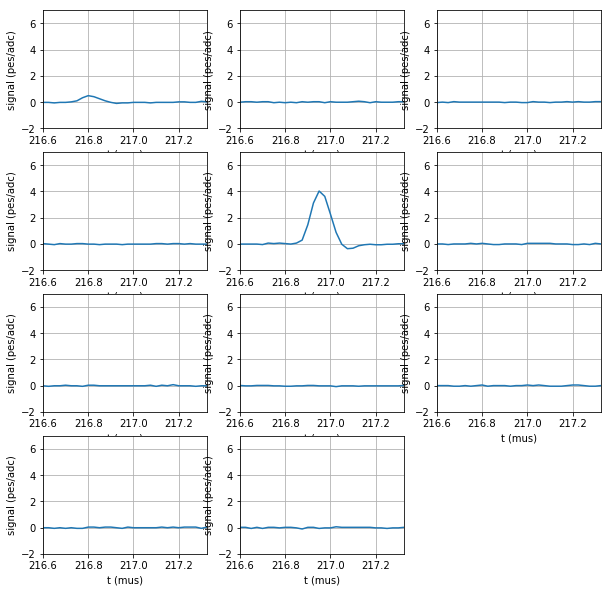

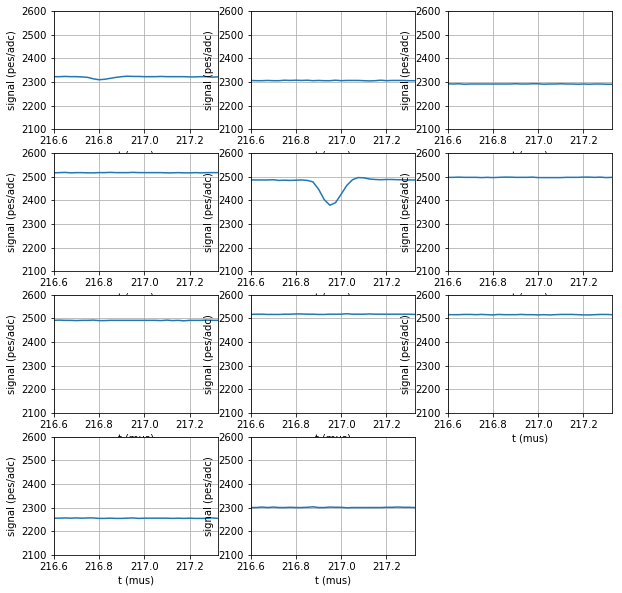

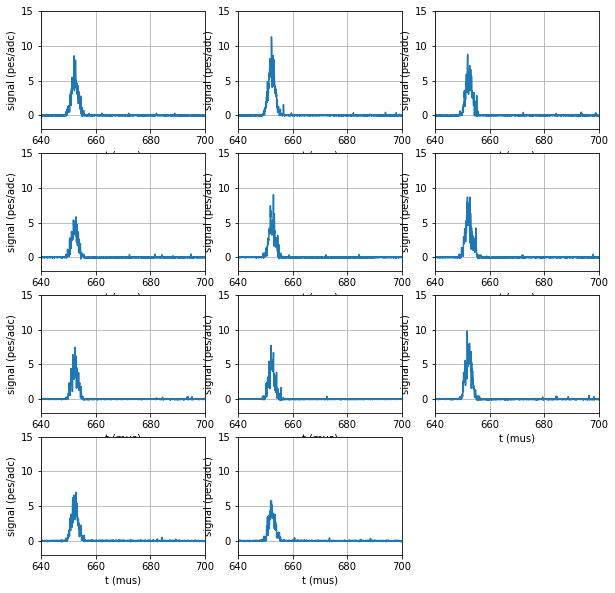

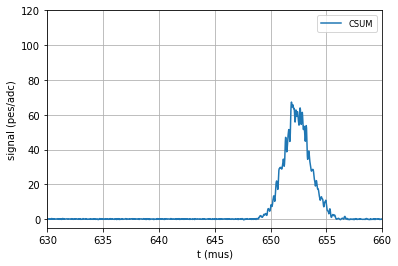

----------


In [32]:
multiplicity = []
energies = []

no_m_ev = []
#no_m_s1 = []

for f in files:
    
    with tb.open_file(f, 'r') as h5rwf:

        pmtrwf, pmtblr, sipmrwf = tbl.get_vectors(h5rwf)
        NEVT, NPMT, PMTWL = pmtrwf.shape
        NEVT, NSIPM, SIPMWL = sipmrwf.shape
        
        print(str(NEVT) + ' in: ' + f + '... ')

        for event in range(0,NEVT):
            if len(energies) >= 1500: break

            # Get cwf csum_mau
            RWF = pmtrwf[event]
            CWF = blr.deconv_pmt(RWF,
                                 coeff_c,
                                 coeff_blr,
                                 pmt_active,
                                 n_baseline  = 48000,
                                 thr_trigger = 5)

            CAL_PMT, CAL_PMT_MAU = cpf.calibrated_pmt_mau(
                                   CWF,
                                   adc_to_pes,
                                   pmt_active = pmt_active,
                                   n_MAU   = 100,
                                   thr_MAU =   3)
            csum, csum_mau = cpf.calibrated_pmt_sum(CWF,adc_to_pes, pmt_active)

            # Find s1s ## SET tmin and tmax appropriately!!
            s1par = S12Params(tmin=0*units.mus, 
                              tmax=640*units.mus, 
                              lmin=6, lmax=40, 
                              stride=4, rebin=False)
            s1_ene, s1_indx = cpf.wfzs(csum_mau, threshold=0.5)
            
            
            try:
                S1 = cpf.find_S12(s1_ene, s1_indx, **s1par._asdict())
            except IndexError:
                if s1_ene != 0 or s1_indx !=0: 
                    print(s1_ene, s1_indx, **s1par._asdict())
                    raise
            
            # Will discard evts with multiple S1s
            if len(S1) != 1: continue

            # (there can pe multiple S1s in each event)
            for nums1, s_1 in enumerate(S1):

                t_buffer = 300 * units.ns
                # Set up params for searching individual pmt cal mau waveforms
                s1par  = S12Params(tmin=(S1[s_1][0][ 0] - t_buffer), 
                                   tmax=(S1[s_1][0][-1] + t_buffer), 
                                   lmin=3, 
                                   lmax=40, 
                                   stride=4, 
                                   rebin=False)

                # Dict for storing individual pmt s1s
                PMT_S1 = {}      
                for pmt in pmt_active:

                    # See if there is a corresponding S1 in this PMT
                    s1_ene, s1_indx = cpf.wfzs(CAL_PMT_MAU[pmt], threshold=0.1)
                    try:
                        PMT_S1[pmt] = cpf.find_S12(s1_ene, s1_indx, **s1par._asdict())
                    except IndexError:
                        if len(s1_ene) != 0 and len(s1_indx) != 0: 
                            print(s1_ene, s1_indx, **s1par._asdict())
                            raise

                # Record multiplicity
                multiplicity.append(compare_S1(S1, PMT_S1, peak=0, tol=0.5*units.mus))
                
                #print(multiplicity[-1])
                if multiplicity[-1] < 3:
                    print('----------')
                    print(S1)
                    
                    mpl.plot_signal_vs_time_mus(csum, t_min=0, t_max=1300, signal_min=-5, signal_max=40, label='CSUM')
                    plt.show()
                    mpl.plot_pmt_signals_vs_time_mus(CAL_PMT,
                             pmt_active = pmt_active,
                             t_min      = 0,
                             t_max      = 1300,
                             signal_min =  -2,
                             signal_max =  10)
                    plt.show()
                    
                    mpl.plot_pmt_signals_vs_time_mus(CAL_PMT,
                             pmt_active = pmt_active,
                             t_min      = (S1[s_1][0][ 0] - t_buffer) / 1000,
                             t_max      = (S1[s_1][0][-1] + t_buffer) / 1000,
                             signal_min = -2,
                             signal_max =  7)
                    plt.show()
                    
                    mpl.plot_pmt_signals_vs_time_mus(RWF,
                             pmt_active = pmt_active,
                             t_min      = (S1[s_1][0][ 0] - t_buffer) / 1000,
                             t_max      = (S1[s_1][0][-1] + t_buffer) / 1000,
                             signal_min = 2100,
                             signal_max = 2600)
                    plt.show()
                    
                    mpl.plot_pmt_signals_vs_time_mus(CAL_PMT,
                             pmt_active = pmt_active,
                             t_min      = 640,
                             t_max      = 700,
                             signal_min =  -2,
                             signal_max =  15)
                    plt.show()
                    
                    mpl.plot_signal_vs_time_mus(csum, t_min=630, t_max=660, signal_min=-5, signal_max=120, label='CSUM')
                    plt.show()
                    print('----------')
                if multiplicity[-1] < 3:break
            if multiplicity[-1] < 3:break
        if multiplicity[-1] < 3:break
                
            #if multiplicity[-1]< 3: break
        #if multiplicity[-1]< 3: break            
                    
                                
                #if multiplicity[-1] < 1: 
                #    no_m_ev.append((event, nums1))
                #    no_m_s1.append(())

                # remember the S1's energy
                #energies.append(S1[s_1][1].sum())
                
                # Looking at multiple s1s from same evt is complicated
                #break
            
multiplicity = np.array(multiplicity)      

Sometimes it is not finding the S1

In [ ]:
print(len(no_m_ev))
print(len(multiplicity))

In [ ]:
def plot_mult_heatmap(energies, multiplicity):
    fig = plt.figure(figsize=(20,15))
    ax  = plt.gca()
    """
    h, x, y = np.histogram2d(energies, multiplicity, bins=(range(2000), 
                             range(len(pmt_active)+2)), 
                             range=None, normed=False, weights=None)                          
    """
    
    # Adding and subtracting .5 to center bins
    plt.hist2d(energies, multiplicity - .5, 
               bins=(len(multiplicity)*3, np.array(range(len(pmt_active) + 2)) - .5), 
               cmap='Spectral_r', normed=True)
    ax.set_xscale('log')
    plt.xlim(0,1000)
    plt.ylim(-.5, len(pmt_active) + .5)
    plt.colorbar()
    plt.xlabel('pes')
    plt.ylabel('multiplicity')
    plt.title('Run: ' + str(run_number))
    plt.show()

In [ ]:
plot_mult_heatmap(energies, multiplicity)

In [ ]:
plt.hist(multiplicity, bins=30 + 1, alpha=0.6, normed=True)
plt.xlabel('multiplicity')
plt.title(str(run_number))
plt.show()

In [ ]:
plt.hist(energies/ multiplicity, bins=np.arange(0, 2, 0.01), facecolor='red', alpha=0.6, normed=True)
plt.grid(True)
plt.xlabel('pes/multiplicity')
plt.title(str(run_number))
plt.show()